## RandomForest max-summarized

This implements something close to the `melspec-maxp` baseline from the paper [Automatic large-scale classification of bird sounds is strongly improved by unsupervised feature learning](https://peerj.com/articles/488/).


In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import tarfile
import re
import io
import os

import numpy
import pandas
import matplotlib.pyplot as plt
import dask.array
import IPython.display

import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn import metrics

# Custom modules
import dcase2018bad
import features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load dataset

In [9]:
dataset = dcase2018bad.load_dataset()
print(dataset.shape)
dataset.head(3)

(48310, 4)


,itemid,datasetid,hasbird,folder
0,BUK4_20161103_204504_125,PolandNFC,NaN,polandnfc
1,BUK4_20161016_012704_132,PolandNFC,NaN,polandnfc
2,6wichura_deszcz_BUK4_20161005_022304_129,PolandNFC,NaN,polandnfc


In [10]:
with_labels = dataset[dataset.hasbird.notna()].copy()
print(with_labels.shape)
with_labels['hasbird'] = with_labels.hasbird.astype(bool)

(35690, 4)


In [12]:
trainset = with_labels.groupby('datasetid').apply(lambda g: g.sample(n=1000, random_state=1))
trainset.shape

(3000, 4)

In [13]:
examples = list(dcase2018bad.wav_urls(trainset[trainset.hasbird == 1.0]))[10:12]
print('\n'.join(examples))

IPython.display.Audio(examples[0])

https://storage.googleapis.com/dcase2018-bad/birdvox/wav/80dc05ee-4713-4231-a1e9-346b55da3a6a.wav
https://storage.googleapis.com/dcase2018-bad/birdvox/wav/477430fa-5201-4f9e-ae83-833cfdcaf7fc.wav


# Feature extraction

In [14]:
import dask.distributed
scheduler = os.environ.get('DASK_SCHEDULER', None) # set to 'mycluster:port' to use remote cluster

c = dask.distributed.Client(scheduler, n_workers=6)
c

Client Scheduler: tcp://127.0.0.1:44479 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 6 Memory: 40.97 GB


In [0]:
# Upload our custom Python modules to workers
c.upload_file('features.py')
c.upload_file('dcase2018bad.py')

In [16]:
# 64-band melspectrogram max-summarized
train_F = features.extract(dcase2018bad.wav_urls(trainset))
train_F

dask.array<concatenate, shape=(3000, 64), dtype=float64, chunksize=(50, 64)>

### Compute features

In [17]:
train_X = train_F.compute()
train_X[0,:]

array([1.00000000e+00, 4.36446942e-01, 1.00000000e+00, 9.06298551e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       9.96842660e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       9.49661819e-01, 9.19822054e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 6.39519015e-01, 8.06870856e-01, 5.38941588e-01,
       5.90517680e-01, 7.46953358e-01, 6.16970399e-01, 6.79269130e-01,
       4.35023222e-01, 3.30400748e-01, 3.92049437e-01, 3.10007035e-01,
       2.69903208e-01, 2.70408599e-01, 2.52135446e-01, 2.53233649e-01,
       3.02067559e-01, 3.98417470e-01, 1.71843745e-01, 1.67520141e-01,
       1.68793264e-01, 1.80019194e-01, 1.58734278e-01, 1.11738758e-01,
       9.45613204e-02, 6.19708748e-02, 4.40385226e-02, 2.26021863e-02,
      

# Model

In [82]:
rf = RandomForestClassifier(n_estimators=100, random_state=1)

train_Y = trainset.hasbird
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(train_X, train_Y, test_size=0.3, random_state=1)

grid_params = {
    'min_samples_leaf': numpy.linspace(0.01, 0.10, 20),
}
gridsearch = GridSearchCV(rf, grid_params, cv=5, return_train_score=True, refit=True, scoring='roc_auc')
gridsearch.fit(X_train, Y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': array([0.01   , 0.01474, 0.01947, 0.02421, 0.02895, 0.03368, 0.03842,
       0.04316, 0.04789, 0.05263, 0.05737, 0.06211, 0.06684, 0.07158,
       0.07632, 0.08105, 0.08579, 0.09053, 0.09526, 0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


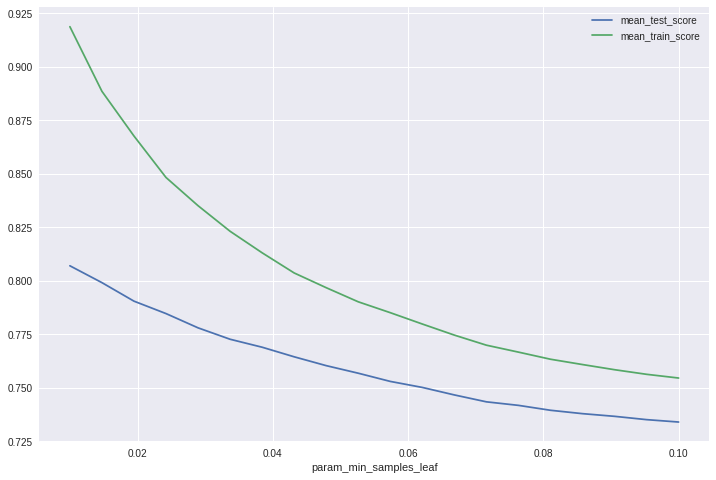

In [86]:
grid = pandas.DataFrame(gridsearch.cv_results_)
grid.plot(y=['mean_test_score', 'mean_train_score'], x='param_min_samples_leaf', figsize=(12,8))

In [71]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=0.04, random_state=1)
rf.fit(X_train, Y_train)
scorer = metrics.get_scorer('roc_auc')
print('train {:2f}'.format(100*scorer(rf, X_train, Y_train)))
print('test {:2f}'.format(100*scorer(rf, X_test, Y_test)))


train 80.077369
test 76.983633


In [0]:
sizes = numpy.linspace(0.10, 1.0, 20)
l = sklearn.model_selection.learning_curve(rf, X_train, Y_train, train_sizes=sizes, cv=5, scoring='roc_auc')

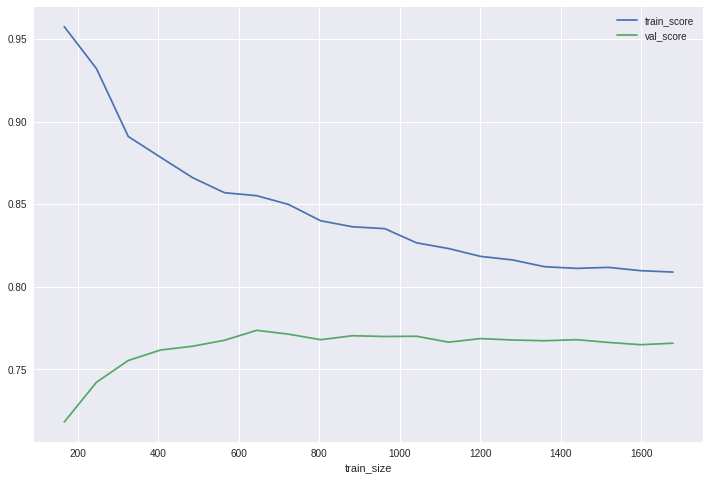

In [85]:
learning = pandas.DataFrame({
    'train_size': l[0],
    'train_score': l[1].mean(axis=1),
    'val_score': l[2].mean(axis=1),
})
learning.plot(x='train_size', figsize=(12,8))